# Deep Learning

_When you come to a fork in the road, take it_ - Yogi Berra 

Concepts: 
- Word Embeddings
- Feedforward Neural Networks

References:

- Geoffrey E. Hinton, Nitish Srivastava, Alex Krizhevsky, Ilya Sutskever, 
Ruslan R. Salakhutdinov, July 2012, "Improving neural networks by preventing 
co-adaptation of feature detectors"

- Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.

- Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean, 2013, "Efficient Estimation of Word Representations in Vector Space"

- Greg Durrett, 2023, "CS388 Natural Language Processing course materisl", retrieved from https://www.cs.utexas.edu/~gdurrett/courses/online-course/materials.html

- Philipp Krahenbuhl, 2020, "CS395T Deep Learning course materials", retrieved from http://www.philkr.net/dl_class/material



In [9]:
import numpy as np
import random
import time
import pandas as pd
from pandas import DataFrame, Series
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
import torch
from torch import nn
import torchinfo
import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from finds.database import MongoDB, SQL, RedisDB
from finds.unstructured import Unstructured, Edgar, Vocab
from finds.structured import BusDay, CRSP, PSTAT
from finds.readers import Sectoring
from finds.utils import Store
from secret import credentials, paths
# %matplotlib qt
# jupyter-notebook --NotebookApp.iopub_data_rate_limit=1.0e12
VERBOSE = 0
outdir = paths['scratch']
store = Store(outdir, ext='pkl')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device is', device)

device is cuda


In [10]:
# dimension of embeddings vector
embeddings_dim = 300
# max size of vocab
vocab_len = 15000

In [11]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
crsp = CRSP(sql, bd, rdb, verbose=VERBOSE)
pstat = PSTAT(sql, bd, verbose=VERBOSE)
ed = Edgar(paths['10X'], zipped=True, verbose=VERBOSE)

Last FamaFrench Date 2024-03-28 00:00:00


## Text classification

In [12]:
# Retrieve universe of stocks
univ = crsp.get_universe(bd.endmo(20221231))

In [13]:
# lookup company names
comnam = crsp.build_lookup(source='permno', target='comnam', fillna="")
univ['comnam'] = comnam(univ.index)

In [14]:
# lookup ticker symbols
ticker = crsp.build_lookup(source='permno', target='ticker', fillna="")
univ['ticker'] = ticker(univ.index)

In [15]:
# lookup sic codes from Compustat, and map to FF 10-sector code
sic = pstat.build_lookup(source='lpermno', target='sic', fillna=0)
industry = Series(sic[univ.index], index=univ.index)
industry = industry.where(industry > 0, univ['siccd'])
sectors = Sectoring(sql, scheme='codes10', fillna='')   # supplement from crosswalk
univ['sector'] = sectors[industry]

In [16]:
# retrieve 2023 bus10K's
item, form = 'bus10K', '10-K'
rows = DataFrame(ed.open(form=form, item=item))
found = rows[rows['date'].between(20230101, 20231231)]\
             .drop_duplicates(subset=['permno'], keep='last')\
             .set_index('permno')

### Tagging and Lemmatizing



In [ ]:
# !nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()
bus = {}
for permno in tqdm(found.index):
    if permno not in univ.index:
        continue
    doc = word_tokenize(ed[found.loc[permno, 'pathname']].lower())
    tags = pos_tag(doc)
    nouns = [lemmatizer.lemmatize(w[0]) for w in tags
             if w[1] in ['NN', 'NNS'] and w[0].isalpha() and len(w[0]) > 2]
    if len(nouns) > 100:
        bus[permno] = nouns
store['nouns'] = bus

In [17]:
bus = store.load('nouns')
permnos = list(bus.keys())

In [18]:
# Create textual dataset and encode labels
words = Counter()
for nouns in bus.values():
    words.update(list(nouns))
vocab = Vocab(words.keys())
print('vocab len:', len(vocab))

vocab len: 79581


In [19]:
labels = []
x_all = []
for permno, nouns in bus.items():
    x = vocab.get_index([noun for noun in nouns])
    if sum(x):
        labels.append(univ.loc[permno, 'sector'])
        x_all.append(x)
class_encoder = LabelEncoder().fit(labels)    # .inverse_transform()
y_all = class_encoder.transform(labels)

In [20]:
store['dan'] = dict(y_all=y_all, x_all=x_all)

In [21]:
# retrieve from previously stored
y_all, x_all = store['dan'].values()

## Word Embeddings

- Continuous BOW, skip-gram, Word2Vec, GloVe matrix factorization


### GloVe


In [22]:
# Retrieve GloVe embeddings
glove_file = f"glove.6B.{embeddings_dim}d.txt"
#source = "https://nlp.stanford.edu/data/glove.6B.zip"
#response = requests.get(source)
#source = io.BytesIO(response.content)
#source = paths['scratch'] / 'glove.6B.zip'
#with zipfile.ZipFile(source).open(glove_file) as f:
filename = paths['scratch'] / glove_file
embeddings = pd.read_csv(filename, sep=" ", quoting=3,
                         header=None, index_col=0, low_memory=True)
embeddings.index = embeddings.index.astype(str).str.lower()
print(embeddings.shape)

# Relativize embeddings to words in vocab
vocab.set_embeddings(embeddings)
print(vocab.embeddings.shape)
vocab.dump(outdir / f"dan{embeddings_dim}_{vocab_len}.pkl")

(400000, 300)
(79581, 300)


In [23]:
# load previously saved Vocab
vocab.load(outdir / f"dan{embeddings_dim}_{vocab_len}.pkl")

### Word Vector Arithmetic

It has been noted that these examples are only suggestive of what the vectors may capture, and such arithmetic results are generally not as sharp; they may also show the potential for biases, such as gender roles, implicit in the training samples.


In [24]:
from sklearn.neighbors import NearestNeighbors
analogies = ["man king woman", "paris france tokyo", "big bigger cold"]
for analogy in analogies:
    words = analogy.lower().split()
    vectors = {word: embeddings.loc[word].values for word in words}
    vec = vectors[words[1]] - vectors[words[0]] + vectors[words[2]]

    sim = NearestNeighbors(n_neighbors=1).fit(embeddings)
    neighbors = sim.kneighbors(vec.reshape((1, -1)), n_neighbors=2,
                               return_distance=False).flatten().tolist()
    neighbors = [k for k in neighbors if embeddings.index[k] not in words]
    print(f"{words[1]} - {words[0]} + {words[2]} =",
          [embeddings.index[k] for k in neighbors])

king - man + woman = ['queen']
france - paris + tokyo = ['japan']
bigger - big + cold = ['colder']


## FeedForward Neural Network

- nonlinearity
- hidden layers and size 
- initialization 
- optimization: adam
- dropout

Geoffrey Hinton, et al. in their 2012 paper that first introduced dropout. They
found that using a simple method of 50% dropout for all hidden units and 
20% dropout for input units achieve improved results with a range of 
neural networks on different problem types

It is not used on the output layer.

### Deep Averaging Networks
- Frozen and fine-tuning word embedding vectors


In [112]:
class DAN(nn.Module):
    """Deep Averaging Network for classification"""
    def __init__(self,
                 vocab_dim,
                 num_classes,
                 hidden,
                 embedding,
                 freeze=True):
        super().__init__()
        self.embedding = nn.EmbeddingBag.from_pretrained(embedding)
        self.embedding.weight.requires_grad = not freeze
        D = nn.Dropout(0.0)
        V = nn.Linear(vocab_dim, hidden[0])
        nn.init.xavier_uniform_(V.weight)
        L = [D, V]
        self.drops = [D]
        for in_dim, out_dim in zip(hidden, hidden[1:] + [num_classes]):
            L.append(nn.ReLU())   # nonlinearity layer
            D = nn.Dropout(0.0)
            self.drops.append(D)
            L.append(D)           # dropout layer
            W = nn.Linear(in_dim, out_dim)   # dense linear layer
            nn.init.xavier_uniform_(W.weight)
            L.append(W)
        self.network = nn.Sequential(*L)
        self.classifier = nn.LogSoftmax(dim=-1)  # output is (N, C) logits

    def set_dropout(self, dropout):
        if dropout:
            self.drops[0] = 0.2    # input layer
            for i in range(1, len(self.drops)):    # hidden layers
                self.drops[i].p = 0.5
        else:
            for i in range(len(self.drops)):
                self.drops[i].p = 0.0

    def set_freeze(self, freeze):
        """To freeze part of the model (embedding layer)"""
        self.embedding.weight.requires_grad = not freeze

    def forward(self, x):
        """Return tensor of log probabilities"""
        return self.classifier(self.network(self.embedding(x)))

    def predict(self, x):
        """Return predicted int class of input tensor vector"""
        return torch.argmax(self(x), dim=1).int().tolist()

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self    

__Train Models__


In [113]:
# Stratified train_test split
num_classes = len(np.unique(labels))
train_index, test_index = train_test_split(
    np.arange(len(y_all)), stratify=y_all, random_state=42, test_size=0.2)
print(len(x_all), len(y_all), len(train_index), len(test_index), num_classes)
Series(labels).value_counts().rename('count').to_frame()

3559 3559 2847 712 10


,count
Hlth,881
Other,762
HiTec,706
Manuf,344
Shops,321
Durbl,164
NoDur,145
Enrgy,94
Utils,92
Telcm,50


In [130]:
# Model and training parameters
layers = 1
hidden_size = 32
model = DAN(embeddings_dim,
            num_classes,
            hidden=[hidden_size] * layers,
            embedding=torch.FloatTensor(vocab.embeddings)).to(device)
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
DAN                                      --
├─EmbeddingBag: 1-1                      (23,874,300)
├─Sequential: 1-2                        --
│    └─Dropout: 2-1                      --
│    └─Linear: 2-2                       9,632
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       330
├─LogSoftmax: 1-3                        --
Total params: 23,884,262
Trainable params: 9,962
Non-trainable params: 23,874,300

In [131]:
batch_sz = 16
lr = 0.001 
num_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.NLLLoss()

In [132]:
def form_input(docs):
    """Pad lists of index lists to form batch of equal lengths"""
    lengths = [len(doc) for doc in docs]   # length of each doc                     
    max_length = max(1, max(lengths))      # to pad so all lengths equal max        
    out = [doc + ([0] * (max_length-n)) for doc, n in zip(docs, lengths)]
    return torch.LongTensor(out)

In [133]:
accuracy = []
for imodel, (freeze, dropout) in enumerate([(True, False), (False, False), (False, True)]):
    model.set_freeze(freeze=freeze)
    model.set_dropout(dropout=dropout)
    accuracy.append(dict())

    # Loop over epochs
    for epoch in tqdm(range(num_epochs)):
        tic = time.time()

        # Form batches
        random.shuffle(train_index)
        batches = [train_index[i:(i+batch_sz)]
                   for i in range(0, len(train_index), batch_sz)]

        # Train in batches
        total_loss = 0.0
        model.train()
        for batch in batches:  # train by batch
            x = form_input([x_all[idx] for idx in batch]).to(device)
            y = torch.LongTensor([y_all[idx] for idx in batch]).to(device)
            model.zero_grad()                    # reset model gradient
            log_probs = model(x)                 # run model
            loss = loss_function(log_probs, y)   # compute loss
            total_loss += float(loss)
            loss.backward()                      # loss step
            optimizer.step()                     # optimizer step
        model.eval()
        model.save(outdir / f"dan{embeddings_dim}.pt")

        if VERBOSE:
            print(f"Loss {epoch}/{num_epochs} {(freeze, dropout)}:" +
                  f"{total_loss:.1f}")

        with torch.no_grad():   # evaluate test error
            test_pred = [model.predict(form_input([x_all[i]]).to(device))[0]
                         for i in test_index]
            test_gold = [y_all[idx] for idx in test_index]
            test_correct = (np.array(test_pred) == np.array(test_gold)).sum() 
            train_pred = [model.predict(form_input([x_all[i]]).to(device))[0]
                          for i in train_index]
            train_gold = [y_all[idx] for idx in train_index]
            train_correct = (np.array(train_pred) == np.array(train_gold)).sum() 
            accuracy[imodel][epoch] = {
                'loss': total_loss,
                'train': train_correct/len(train_gold),
                'test': test_correct/len(test_gold)}

            if VERBOSE:
                print(freeze,
                      dropout,
                      epoch,
                      int(time.time() - tic),
                      optimizer.param_groups[0]['lr'],
                      train_correct/len(train_gold),
                      test_correct/len(test_gold))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [03:56<00:00,  4.73s/it]


__Confusion matrix__


In [134]:
classes = class_encoder.classes_
cf_train = DataFrame(confusion_matrix(train_gold, train_pred),
                     index=pd.MultiIndex.from_product([['Actual'], classes]),
                     columns=pd.MultiIndex.from_product([['Predicted'], classes]))
cf_test = DataFrame(confusion_matrix(test_gold, test_pred),
                    index=pd.MultiIndex.from_product([['Actual'], classes]),
                    columns=pd.MultiIndex.from_product([['Predicted'], classes]))

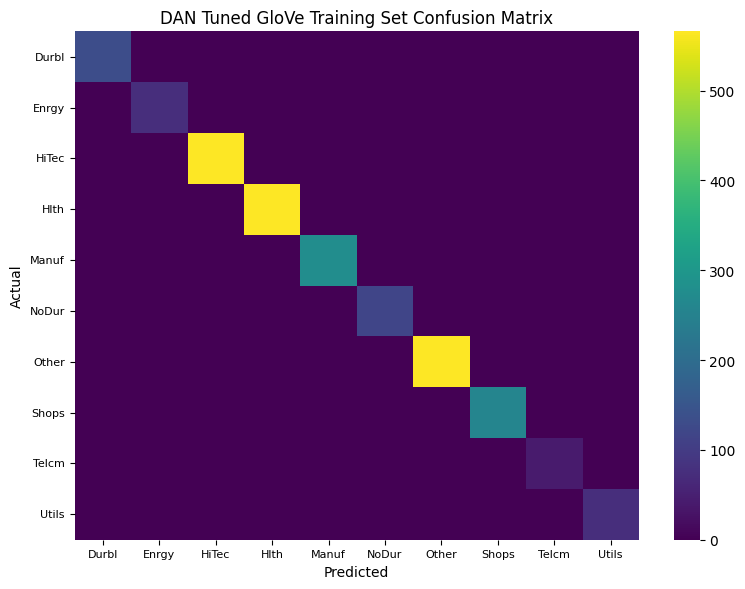

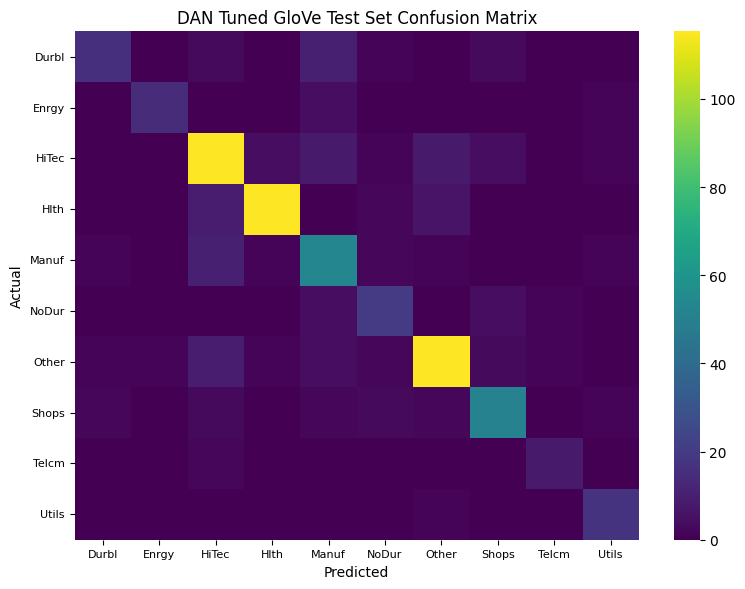

In [135]:
for num, (title, cf) in enumerate({'Training': cf_train,
                                   'Test': cf_test}.items()):
    fig, ax = plt.subplots(num=1+num, clear=True, figsize=(8, 6))
    sns.heatmap(cf, ax=ax, annot= False, fmt='d', cmap='viridis', robust=True,
                yticklabels=class_encoder.classes_,
                xticklabels=class_encoder.classes_)
    ax.set_title(f'DAN Tuned GloVe {title} Set Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.yaxis.set_tick_params(labelsize=8, rotation=0)
    ax.xaxis.set_tick_params(labelsize=8, rotation=0)
    plt.subplots_adjust(left=0.35, bottom=0.25)
    plt.tight_layout()

__Accuracy__


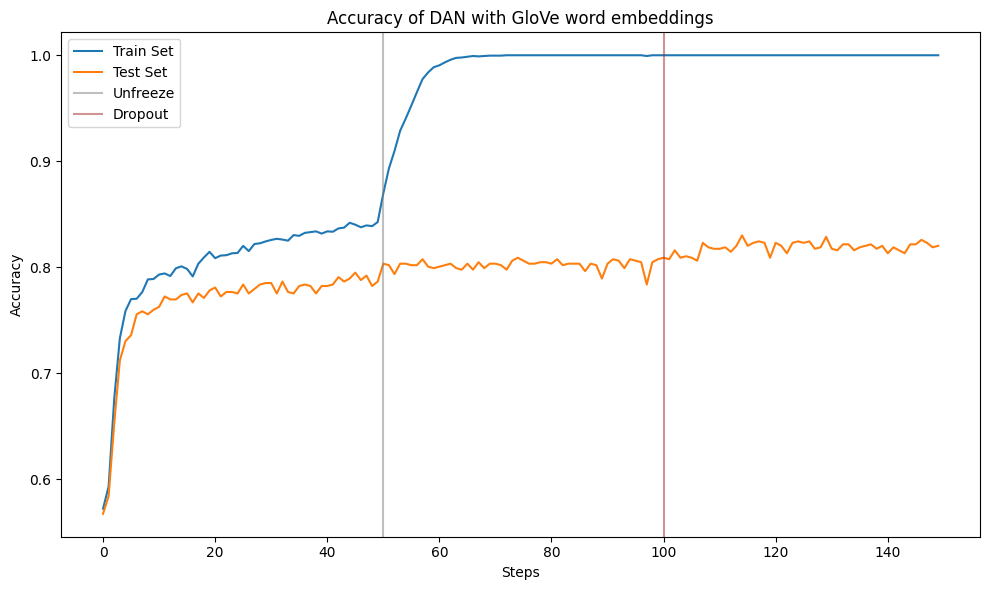

In [136]:
train_accuracy = pd.concat([Series([epoch['train'] for epoch in acc.values()])
                            for acc in accuracy],
                           ignore_index=True)
test_accuracy = pd.concat([Series([epoch['test'] for epoch in acc.values()])
                           for acc in accuracy],
                          ignore_index=True)

fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 6))
train_accuracy.plot(ax=ax)
test_accuracy.plot(ax=ax)
ax.axvline(len(accuracy[0]), c='grey', alpha=0.5)
ax.axvline(len(accuracy[0]) + len(accuracy[1]), c='brown', alpha=0.5)
ax.set_title(f'Accuracy of DAN with GloVe word embeddings')
ax.set_xlabel('Steps')
ax.set_ylabel('Accuracy')
ax.legend(['Train Set', 'Test Set','Unfreeze','Dropout'], loc='upper left')
plt.tight_layout()

In [137]:
# Accuracy when frozen embeddings, unfrozen and with dropouts
p = (len(accuracy[0]) - 1, len(accuracy[0]) + len(accuracy[1]) - 1, -1)
print("Accuracy")
DataFrame({'frozen': [train_accuracy.iloc[p[0]], test_accuracy.iloc[p[0]]], 
           'unfrozen': [train_accuracy.iloc[p[1]], test_accuracy.iloc[p[1]]], 
           'dropout': [train_accuracy.iloc[p[2]], test_accuracy.iloc[p[2]]]},
          index=['train', 'test'])

Accuracy


,frozen,unfrozen,dropout
train,0.842641,1.000000,1.000000
test,0.786517,0.807584,0.820225
